# DSCI100 Project: Predicting Usage of a Minecraft Server

## Introduction

The Pacific Laboratory for Artificial Intelligence (PLAI) is currently running a Minecraft server and collecting data on their actions. Such data can be used to determine the quantity and allocation of resources and efforts. This report seeks to answer the question: Can a user's played hours and age predict subscription to a game-related newsletter in the collected Minecraft player data? This will be done using a k-nearest neighbors (knn) classification model.

The player data recieved contains 196 observations and 7 variables:
 
* experience: character vector describing the adeptness of a player
* subscribe: logical vector if the player is subscribed to a related game newsletter
* hashedEmail: character vector corresponding to a unique individual's email
* played_hours: double precision numerical vector of hours a player has spent on the server
* name: character vector of a player's name
* gender: character vector of a player's gender
* Age: double precision numerical vector of a player's age

There are a few issues that arise especially when building a kknn model, such as the presence of NAs. The model will require numerical distances to calculate nearest neighbours; NA rows must be removed. Additionally, many of the player hours are equal to zero, which is not representative of the users actively involved in the server. Finally, the variable experience could be made into a factor as it contains a select type of strings, although it will not be used in the model. Relevant issues will be addressed in the wrangling of data.

## Methods & Results

To perform the kknn classification model, I firstly address the concerns outlined in the introduction by wrangling the data. I loaded in the tidyverse, repr, and tidymodels packages with the library function. Then, using the filter function, I removed any instances of NAs and zeroes in the Age and played_hours variables respectively. Furthermore, although the subscribe variable is a boolean, I converted it to a factor with mutate as the classification package will not run otherwise. Finally, I selected the relevant variables of subscribe, played_hours, and Age, leaving a tidied dataset for analysis. 109 observations with the 3 variables:

* subscribe: factor variable if the player is subscribed to a related game newsletter
* played_hours: double precision numerical vector of hours a player has spent on the server
* Age: double precision numerical vector of a player's age

In [36]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 6)

In [29]:
players <- read_csv("data/players.csv", show_col_types = FALSE)

players_tidy <- players |>
    filter(played_hours > 0, Age != "NA") |>
    mutate(subscribe = as.factor(subscribe)) |>
    select(played_hours, Age, subscribe)

players_tidy

played_hours,Age,subscribe
<dbl>,<dbl>,<fct>
30.3,9,TRUE
3.8,17,TRUE
0.7,21,TRUE
⋮,⋮,⋮
0.1,44,TRUE
0.3,22,FALSE
2.3,17,FALSE


### Initial Exploratory Analysis

To perform an exploratory initial analysis, I created a visualization with the tidy data using a scatterplot with ggplot. The x-axis depicts age, the y-axis depicts played hours, and the colour/shape depicts the subscription state. I also log scaled the y-axis, as there were many outliers that made the unscaled graph difficult to read; scaling the y-axis allows for a more clear visualization of all the played hours recorded. From the plot, it appeared that there were more subcribers than non-subscribers, which would need to be addressed in the model. There is no clear relationship between player age and hours, although it seems that most players fall between 15 to 25 years old. It also seems that for a higher amount of played hours, a player is likely subscribed, although it is more mixed when the play time decreases.

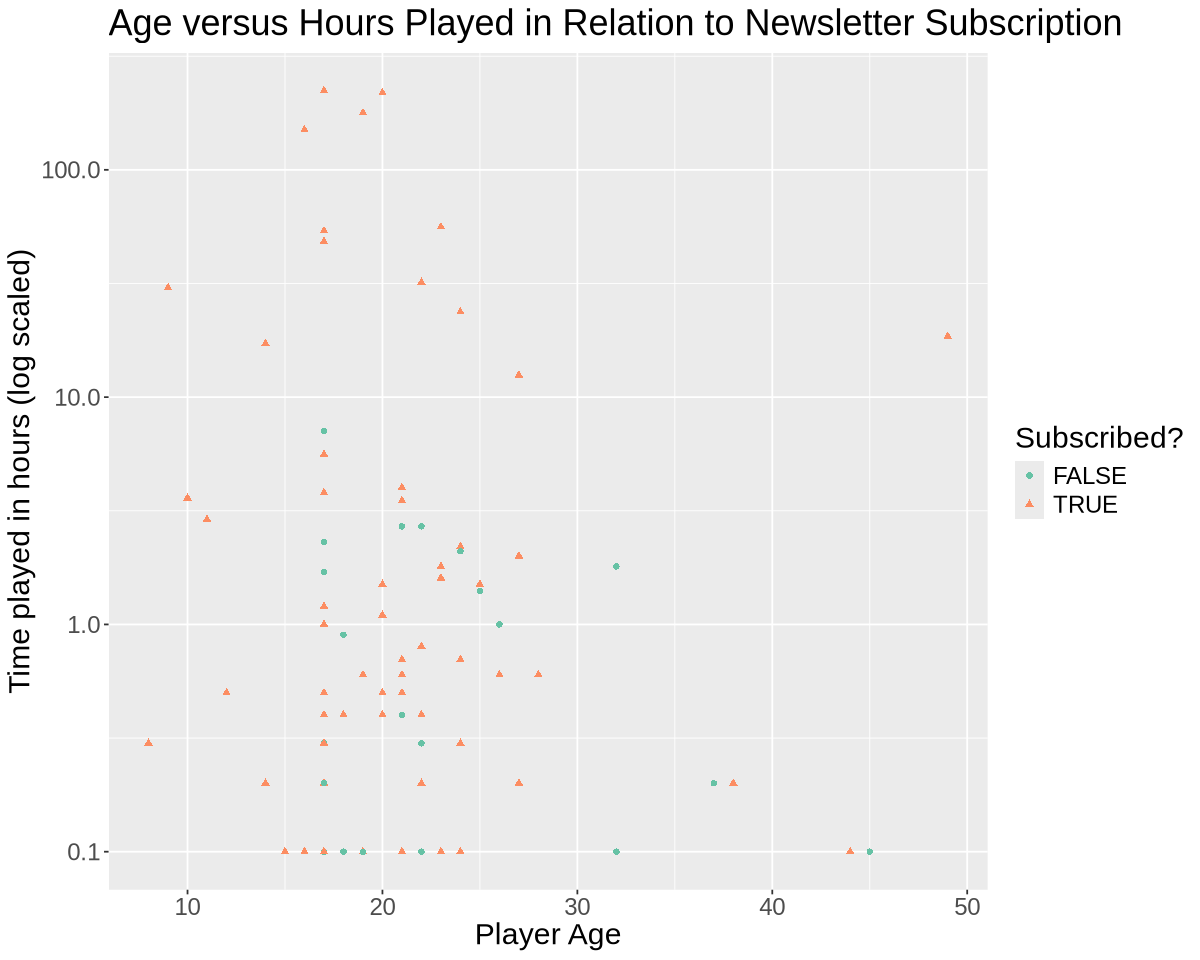

In [43]:
options(repr.plot.height = 8, repr.plot.width = 10)

players_plot <- players_tidy |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe, shape = subscribe)) +
    geom_point() +
    labs(x = "Player Age", y = "Time played in hours (log scaled)", title = "Age versus Hours Played in Relation to Newsletter Subscription",
         color = "Subscribed?", shape = "Subscribed?") +
    theme(text = element_text(size = 18)) +
    scale_color_brewer(palette = "Set2") +
    scale_y_log10()

players_plot

Fig. 1: Scatterplot depicting time played versus age, categorized by if they are subscribed or not.

### Tuning the Classifier

We can now begin the analysis using a classification model. This model is appropriate for this data, given that played_hours and age are both numerical (and therefore can calculate euclidian distances), and that we are classifying players on if they are subscribed or not. However, this model is limited by only accounting for quantitative observations, although there are multiple other qualitative observations recorded in the data. Moreover, this model assumes that any two points that are near each other are similar. Looking at the preliminary analysis, this may not be the case for all points, especially in the bottom half of the graph. Nonetheless, other methods such as linear regression will perform more poorly, as there is no clear linear relationship between the two variables. Clustering would also be unapplicable, as there is already have a subgroup we want to identify (subscribed or not subscribed). As such, I proceeded with using a nearest-neighbors classification model.

Firstly, I split the data into a training and testing set for future validation: 75% is in training while 25% is in testing. To tune the classifer, or choose the optimal k-value, the training set will be further split into 5 different sets for cross validation, a method to prevent overfitting and to test models on unseen data. Also, the data is scaled, centered, and balanced so that all values and categories contribute equally to calculating distance. Considering the size of the dataset, I tested k values between 1 to 10, and graphed the accuracy versus the k value to find the highest. 

neighbors,mean
<dbl>,<dbl>
9,0.665098


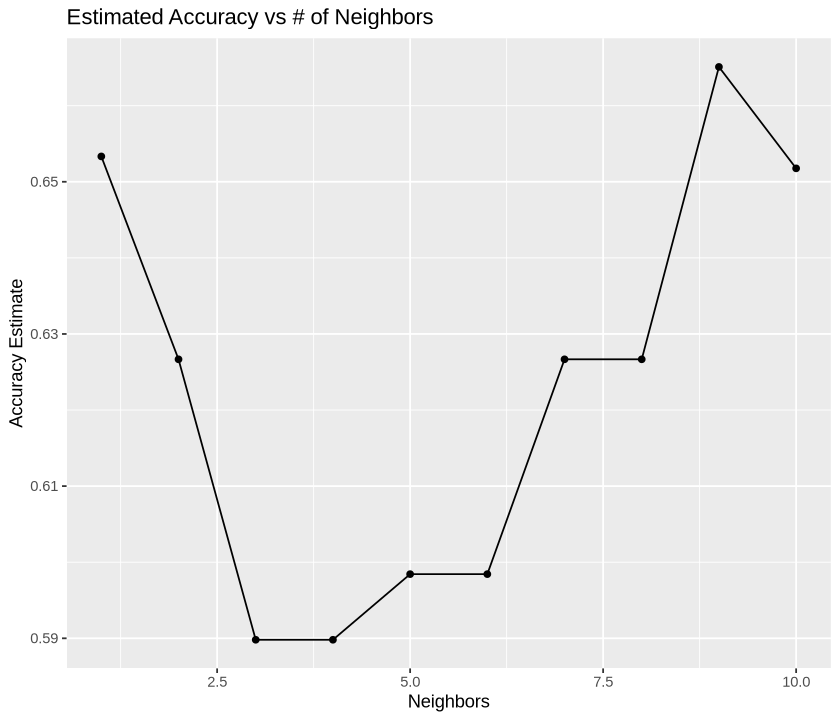

In [71]:
set.seed(100)

# setting up sets, recipe, and specifications
player_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)

player_recipe <- recipe(subscribe ~ . , data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

player_vfold <- vfold_cv(player_training, v = 5, strata = subscribe)

# putting it together in a workflow
k_compare <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# plotted visualization
options(repr.plot.height = 6, repr.plot.width = 7)
k_compare_graph <- k_compare |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Estimated Accuracy vs # of Neighbors")

# best k value & accuracy
k_choice <- k_compare |>
    slice_max(mean, n = 1) |>
    select(neighbors, mean)

k_compare_graph
k_choice

In [72]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_training)

player_predictions <- predict(player_fit, player_testing) |>
    bind_cols(player_testing)

player_model_accuracies <- player_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

player_model_accuracies

player_confusion <- player_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

player_confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5357143


          Truth
Prediction FALSE TRUE
     FALSE     2    8
     TRUE      5   13